In [1]:
# spikingjelly.activation_based.examples.conv_fashion_mnist
# import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from spikingjelly.activation_based import encoding, monitor
from spikingjelly.activation_based import neuron, functional, surrogate, layer
from torch.utils.tensorboard import SummaryWriter
from spikingjelly.activation_based import lava_exchange

import os
import time
import argparse
from torch.cuda import amp
import sys
import datetime
from spikingjelly import visualizing
import numpy as np

device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)
from matplotlib import pyplot as plt


cuda


In [2]:
# tau = 2.0
timesteps = 10
EPOCHS=100 #set to 50 epochs bc of diminishing returns
AMP=True #automatic mixed precision training
lr= 0.001
batch_size=1
num_workers = 10
root = './FMNIST'
train_set = torchvision.datasets.FashionMNIST(
    root=root,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# train_loader = torch.utils.data.DataLoader(
#     dataset=train_set,
#     batch_size=batch_size,
#     shuffle=True
# )

test_set = torchvision.datasets.FashionMNIST(
    root=root,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# test_loader = torch.utils.data.DataLoader(
#     dataset=test_set,
#     batch_size=batch_size,
#     shuffle=False
# )

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True
)

Define the Encoders

In [3]:
encoder_poisson = encoding.PoissonEncoder()

[[0.   0.   0.   0.   0.   0.   0.   0.49 0.65 0.6  0.57 0.56 0.61 0.62
  0.69 0.65 0.67 0.68 0.65 0.69 0.62 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.6  0.71 0.68 0.73 0.75 0.45 0.75
  1.   0.53 0.69 0.71 0.68 0.71 0.71 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.66 0.73 0.71 0.69 0.78 0.47 0.7
  0.73 0.5  0.71 0.71 0.72 0.73 0.73 0.16 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.09 0.75 0.71 0.67 0.67 0.71 0.49 0.71
  0.74 0.61 0.61 0.67 0.7  0.71 0.74 0.37 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.29 0.79 0.66 0.67 0.66 0.69 0.42 0.7
  0.67 0.61 0.6  0.73 0.62 0.7  0.74 0.55 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.53 0.74 0.63 0.73 0.62 0.71 0.44 0.69
  0.75 0.54 0.56 0.7  0.66 0.67 0.75 0.55 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.61 0.68 0.68 0.65 0.62 0.76 0.37 0.67
  0.78 0.53 0.58 0.71 0.68 0.66 0.73 0.64 0.   0.   0.   0. 

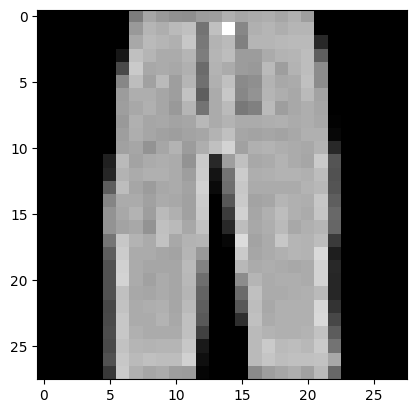

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
         0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         0., 1., 0., 0., 0.,

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

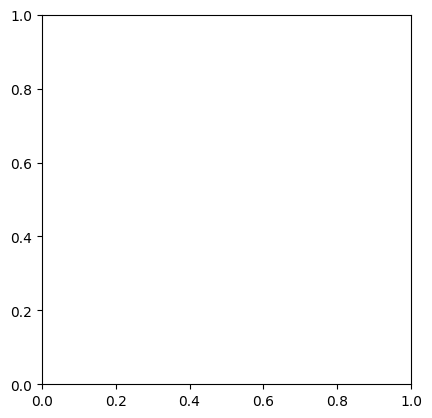

In [18]:
timesteps = 25
encoded_sample = []
for x, label in test_loader:
    numpyx = np.ndarray.round(x.numpy(), decimals=2)
    numpyx = np.reshape(numpyx, newshape=(28,28))
    print(numpyx)
    plt.imshow(numpyx, interpolation='nearest', cmap='gray')
    plt.show()
    x = x.to(device)
    x = torch.reshape(x, (x.shape[0], -1))
    label = label.to(device)
    label_onehot = F.one_hot(label, 10).float()
    for t in range(timesteps):
        encoded_img = encoder_poisson(x)
        print(encoded_img)
        img_np = np.reshape(encoded_img.cpu().numpy(), newshape=(28,28))
        plt.imshow(img_np, interpolation='nearest', cmap='gray')
        plt.show()
        encoded_sample.append(encoded_img)
    break

encoded_img = torch.cat(encoded_sample).cpu().numpy()
figsize = (12, 8)
dpi = 200
visualizing.plot_1d_spikes(spikes=encoded_img, title='spikes', xlabel='simulating step',
                        ylabel='neuron index', figsize=figsize, dpi=dpi)


Create example of Poisson Random Spikes

In [5]:
probs = np.zeros(shape=(10))
x = 0
for i in range(inc.shape[0]):
    probs[i] = x 
    x += 0.1
print(probs)

NameError: name 'inc' is not defined

In [ ]:
timesteps = 25
spikes = []
for t in range(timesteps):
    spike = encoder_poisson(torch.tensor(probs)).unsqueeze(0)
    spikes.append(spike)
s_list = torch.cat(spikes)


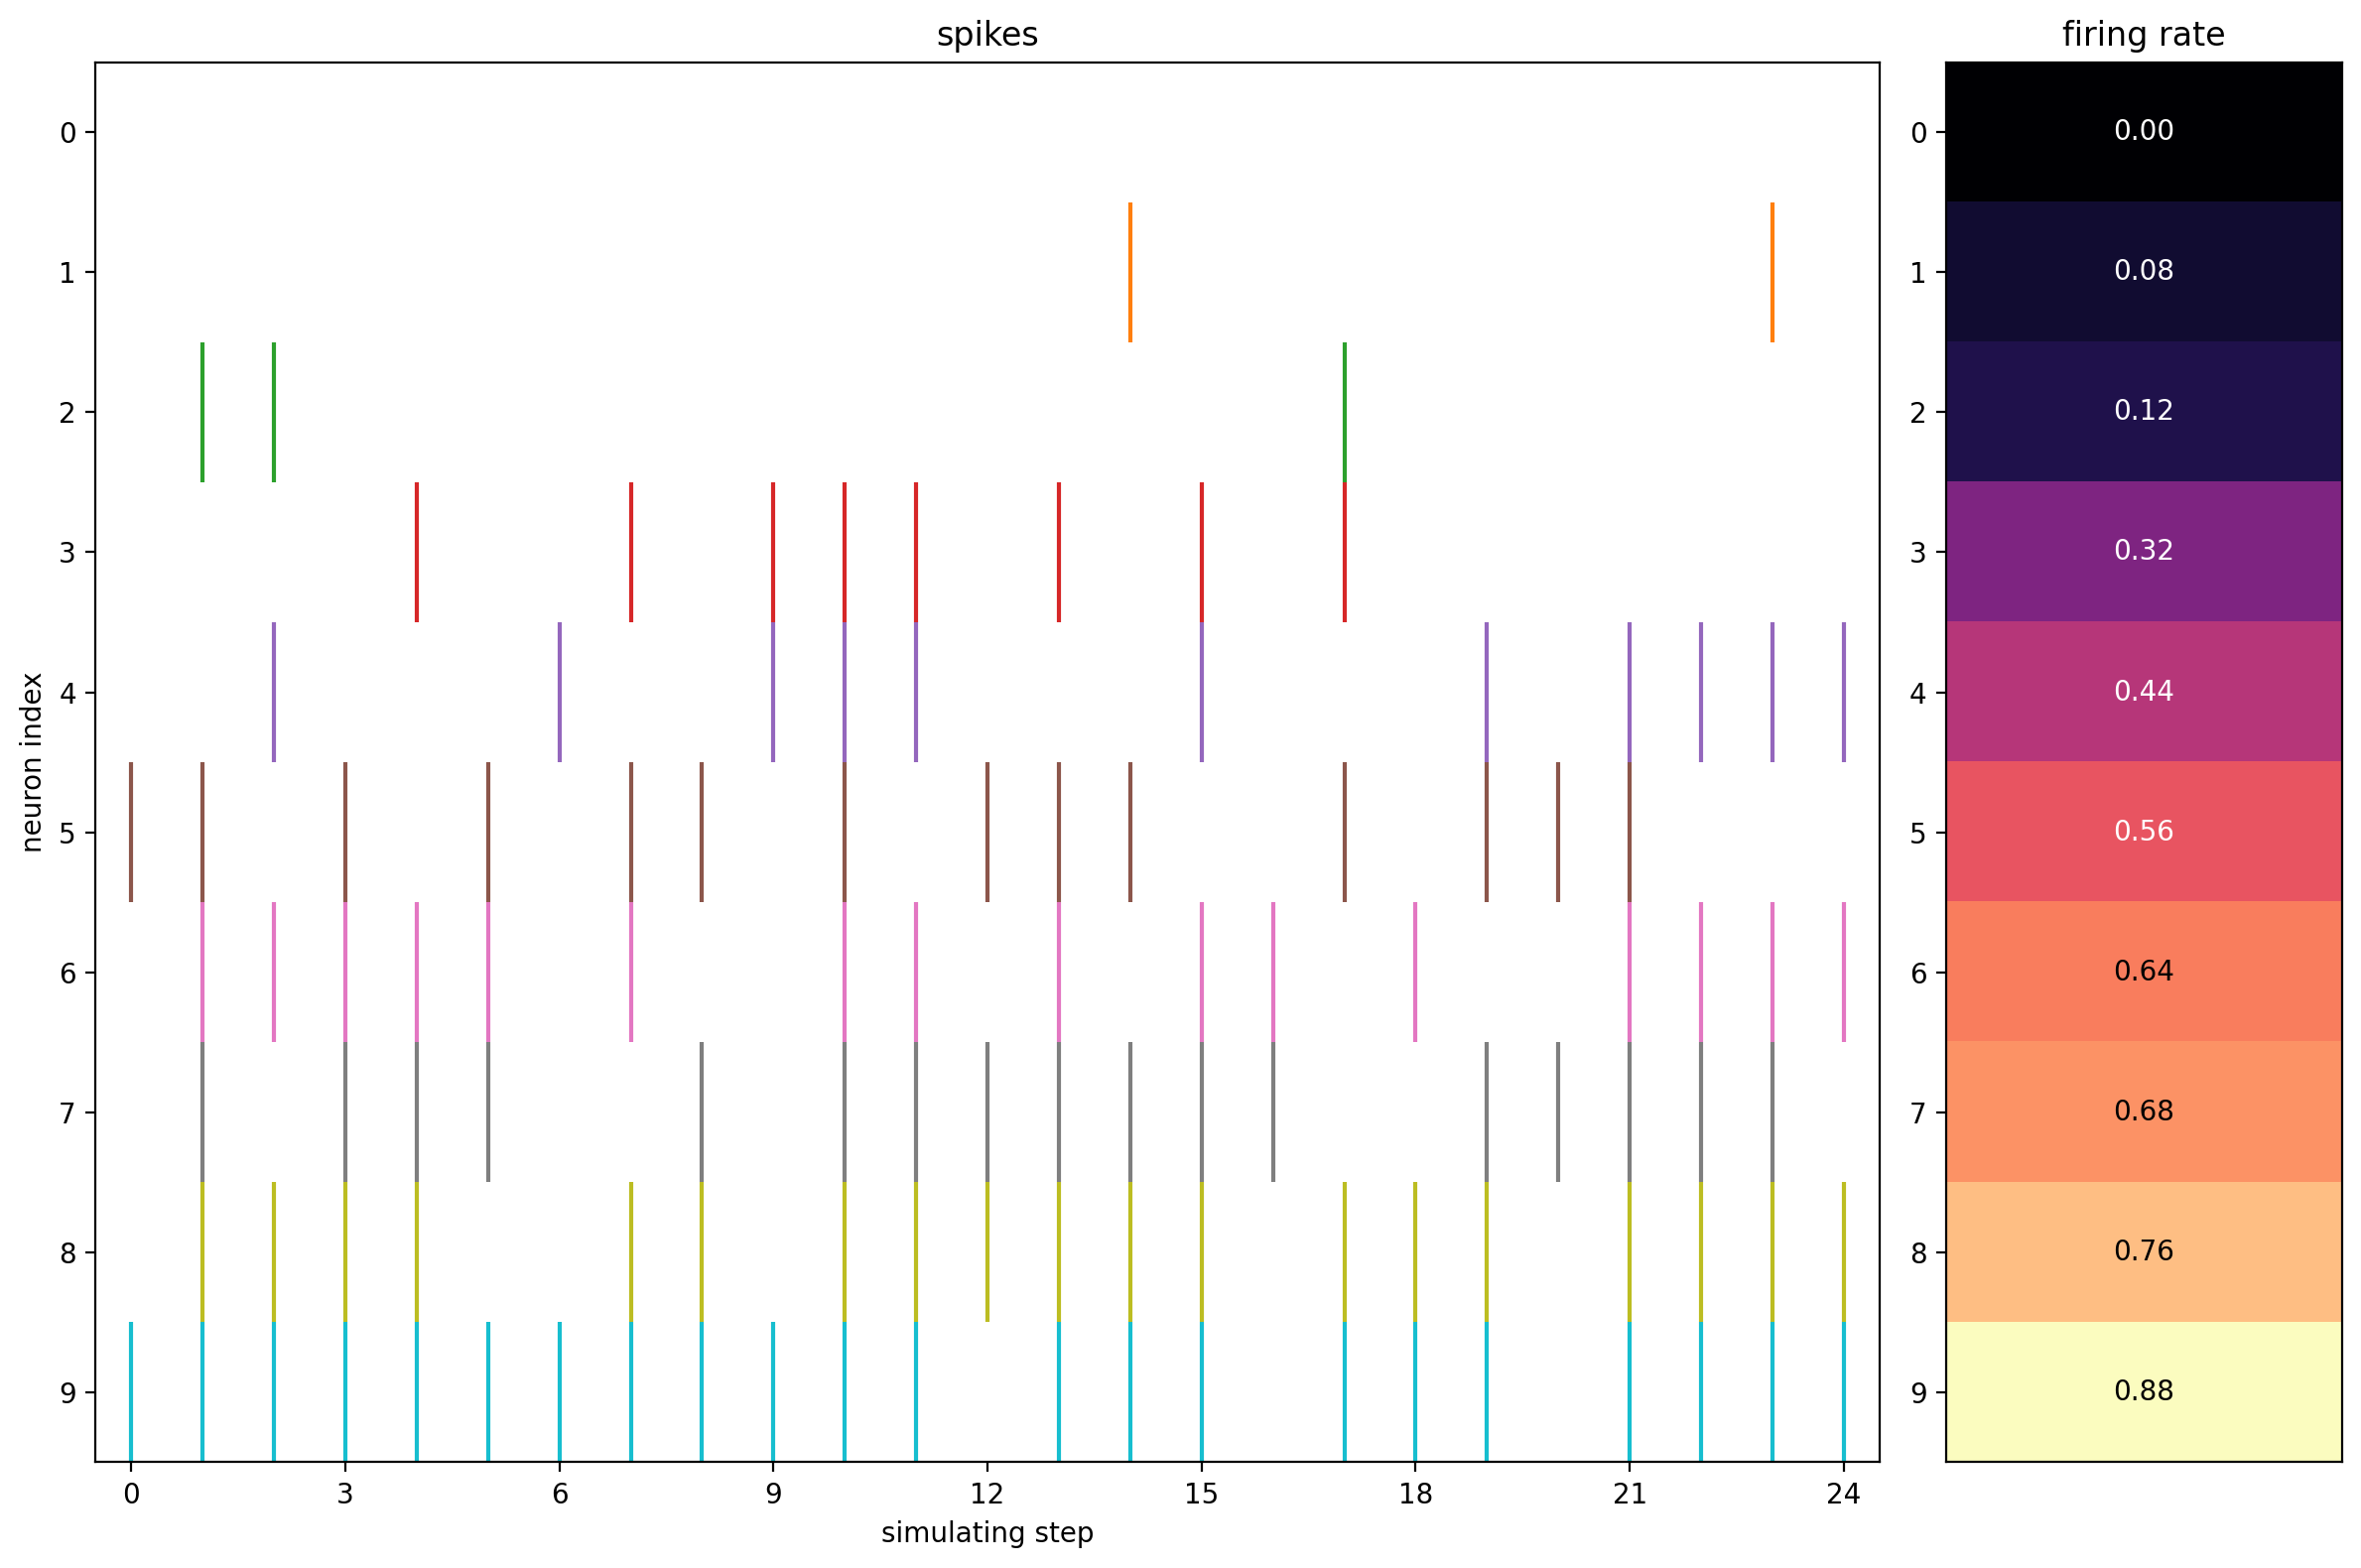

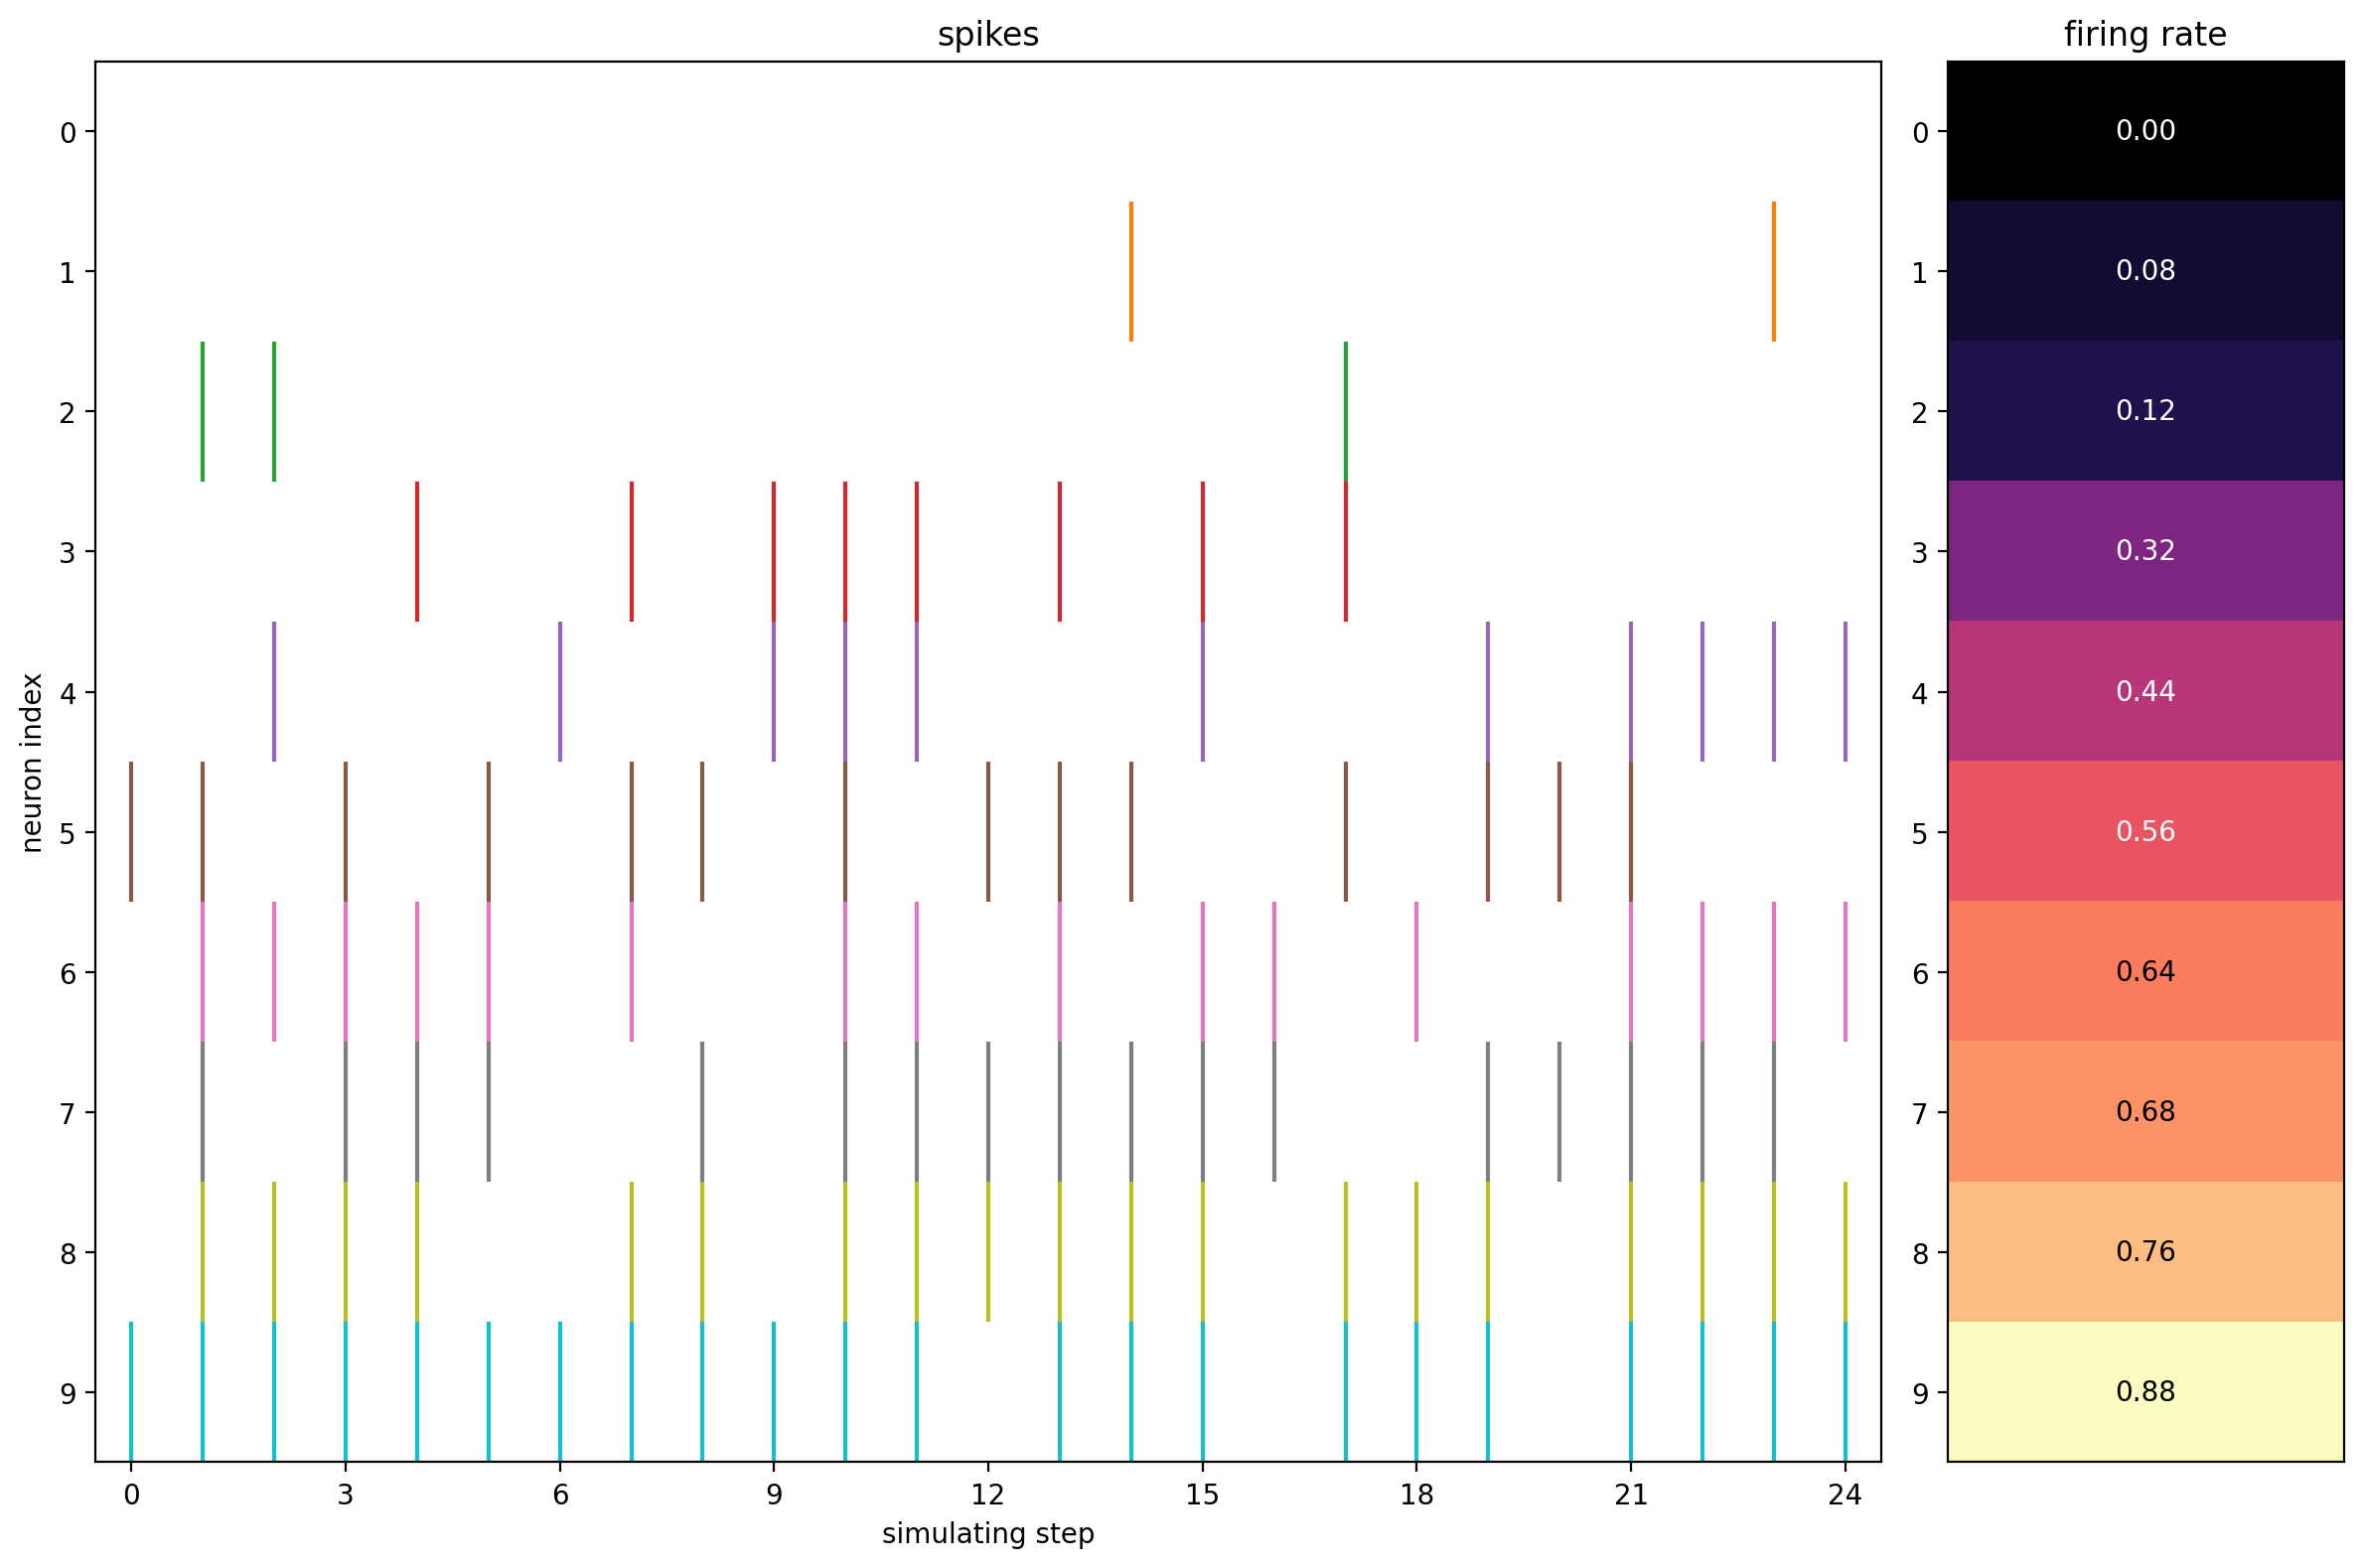

In [ ]:
figsize = (12, 8)
dpi = 200
visualizing.plot_1d_spikes(spikes=s_list.numpy(), title='spikes', xlabel='simulating step',
                        ylabel='neuron index', figsize=figsize, dpi=dpi)